## 1. 读取数据

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('BTC-USD.csv', index_col=0)

In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-04-01,71333.484375,71342.093750,68110.695313,69702.148438,69702.148438,34873527352
2024-04-02,69705.023438,69708.382813,64586.593750,65446.972656,65446.972656,50705240709
2024-04-03,65446.671875,66914.320313,64559.898438,65980.812500,65980.812500,34488018367


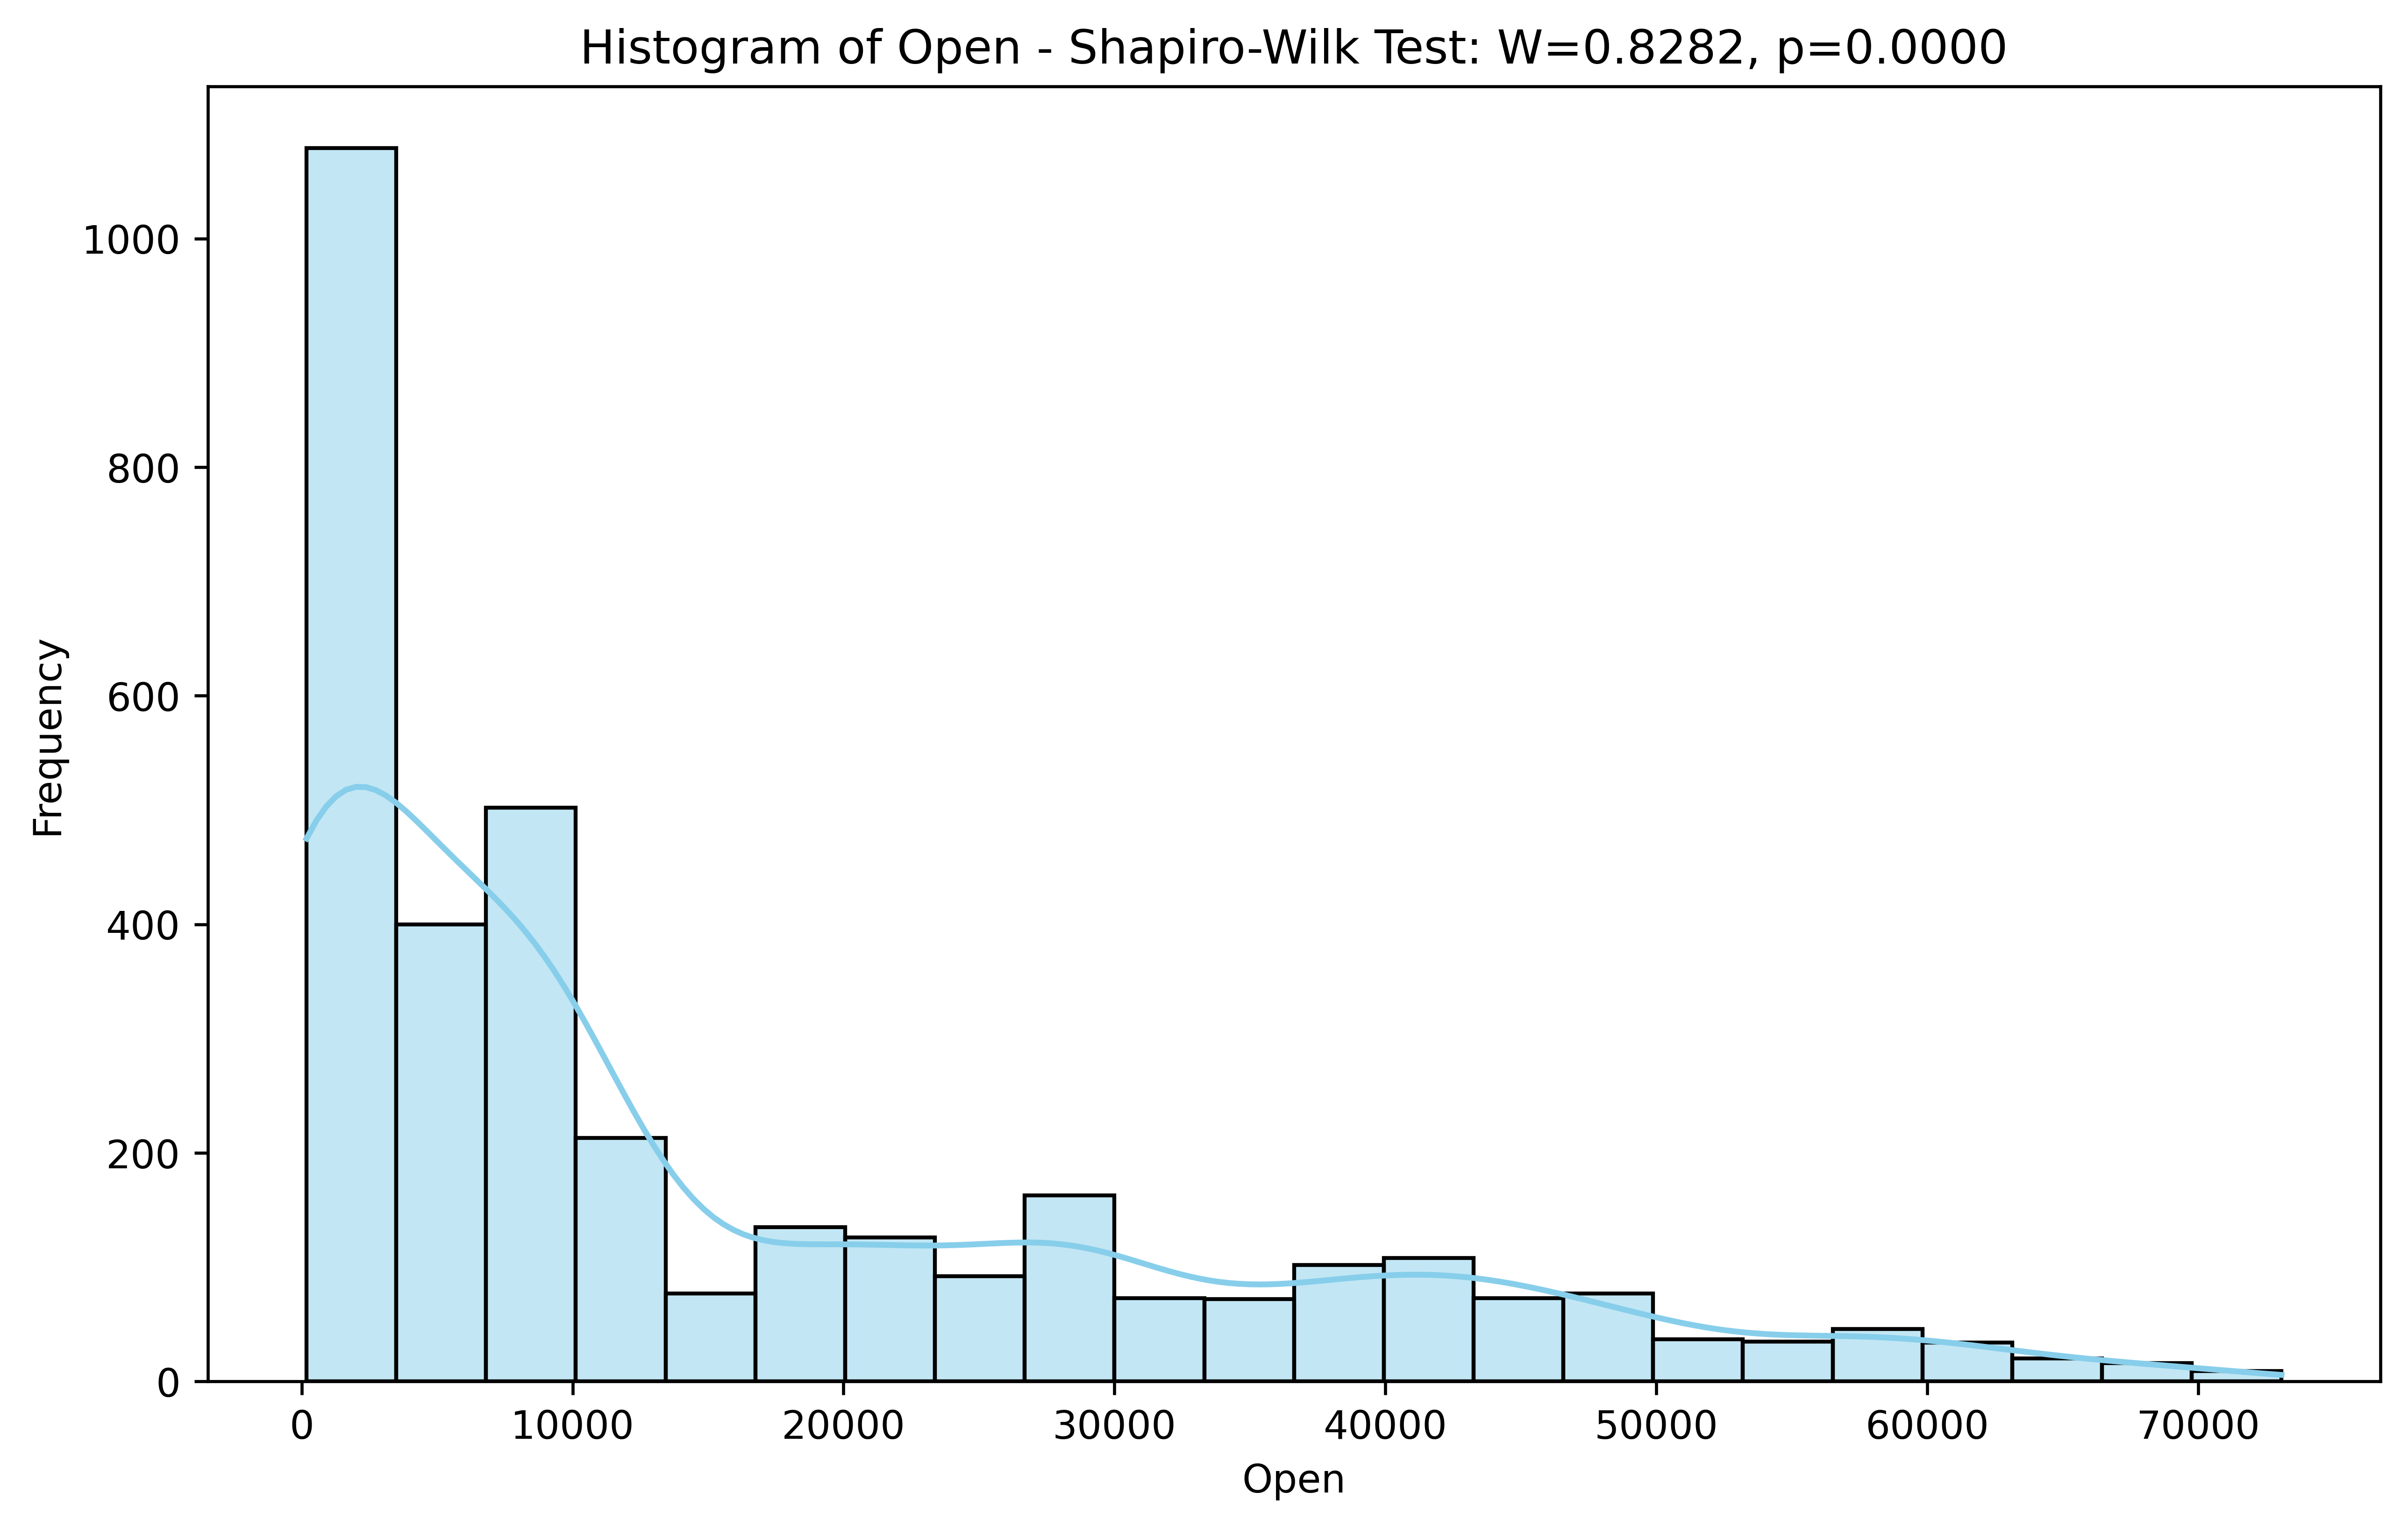

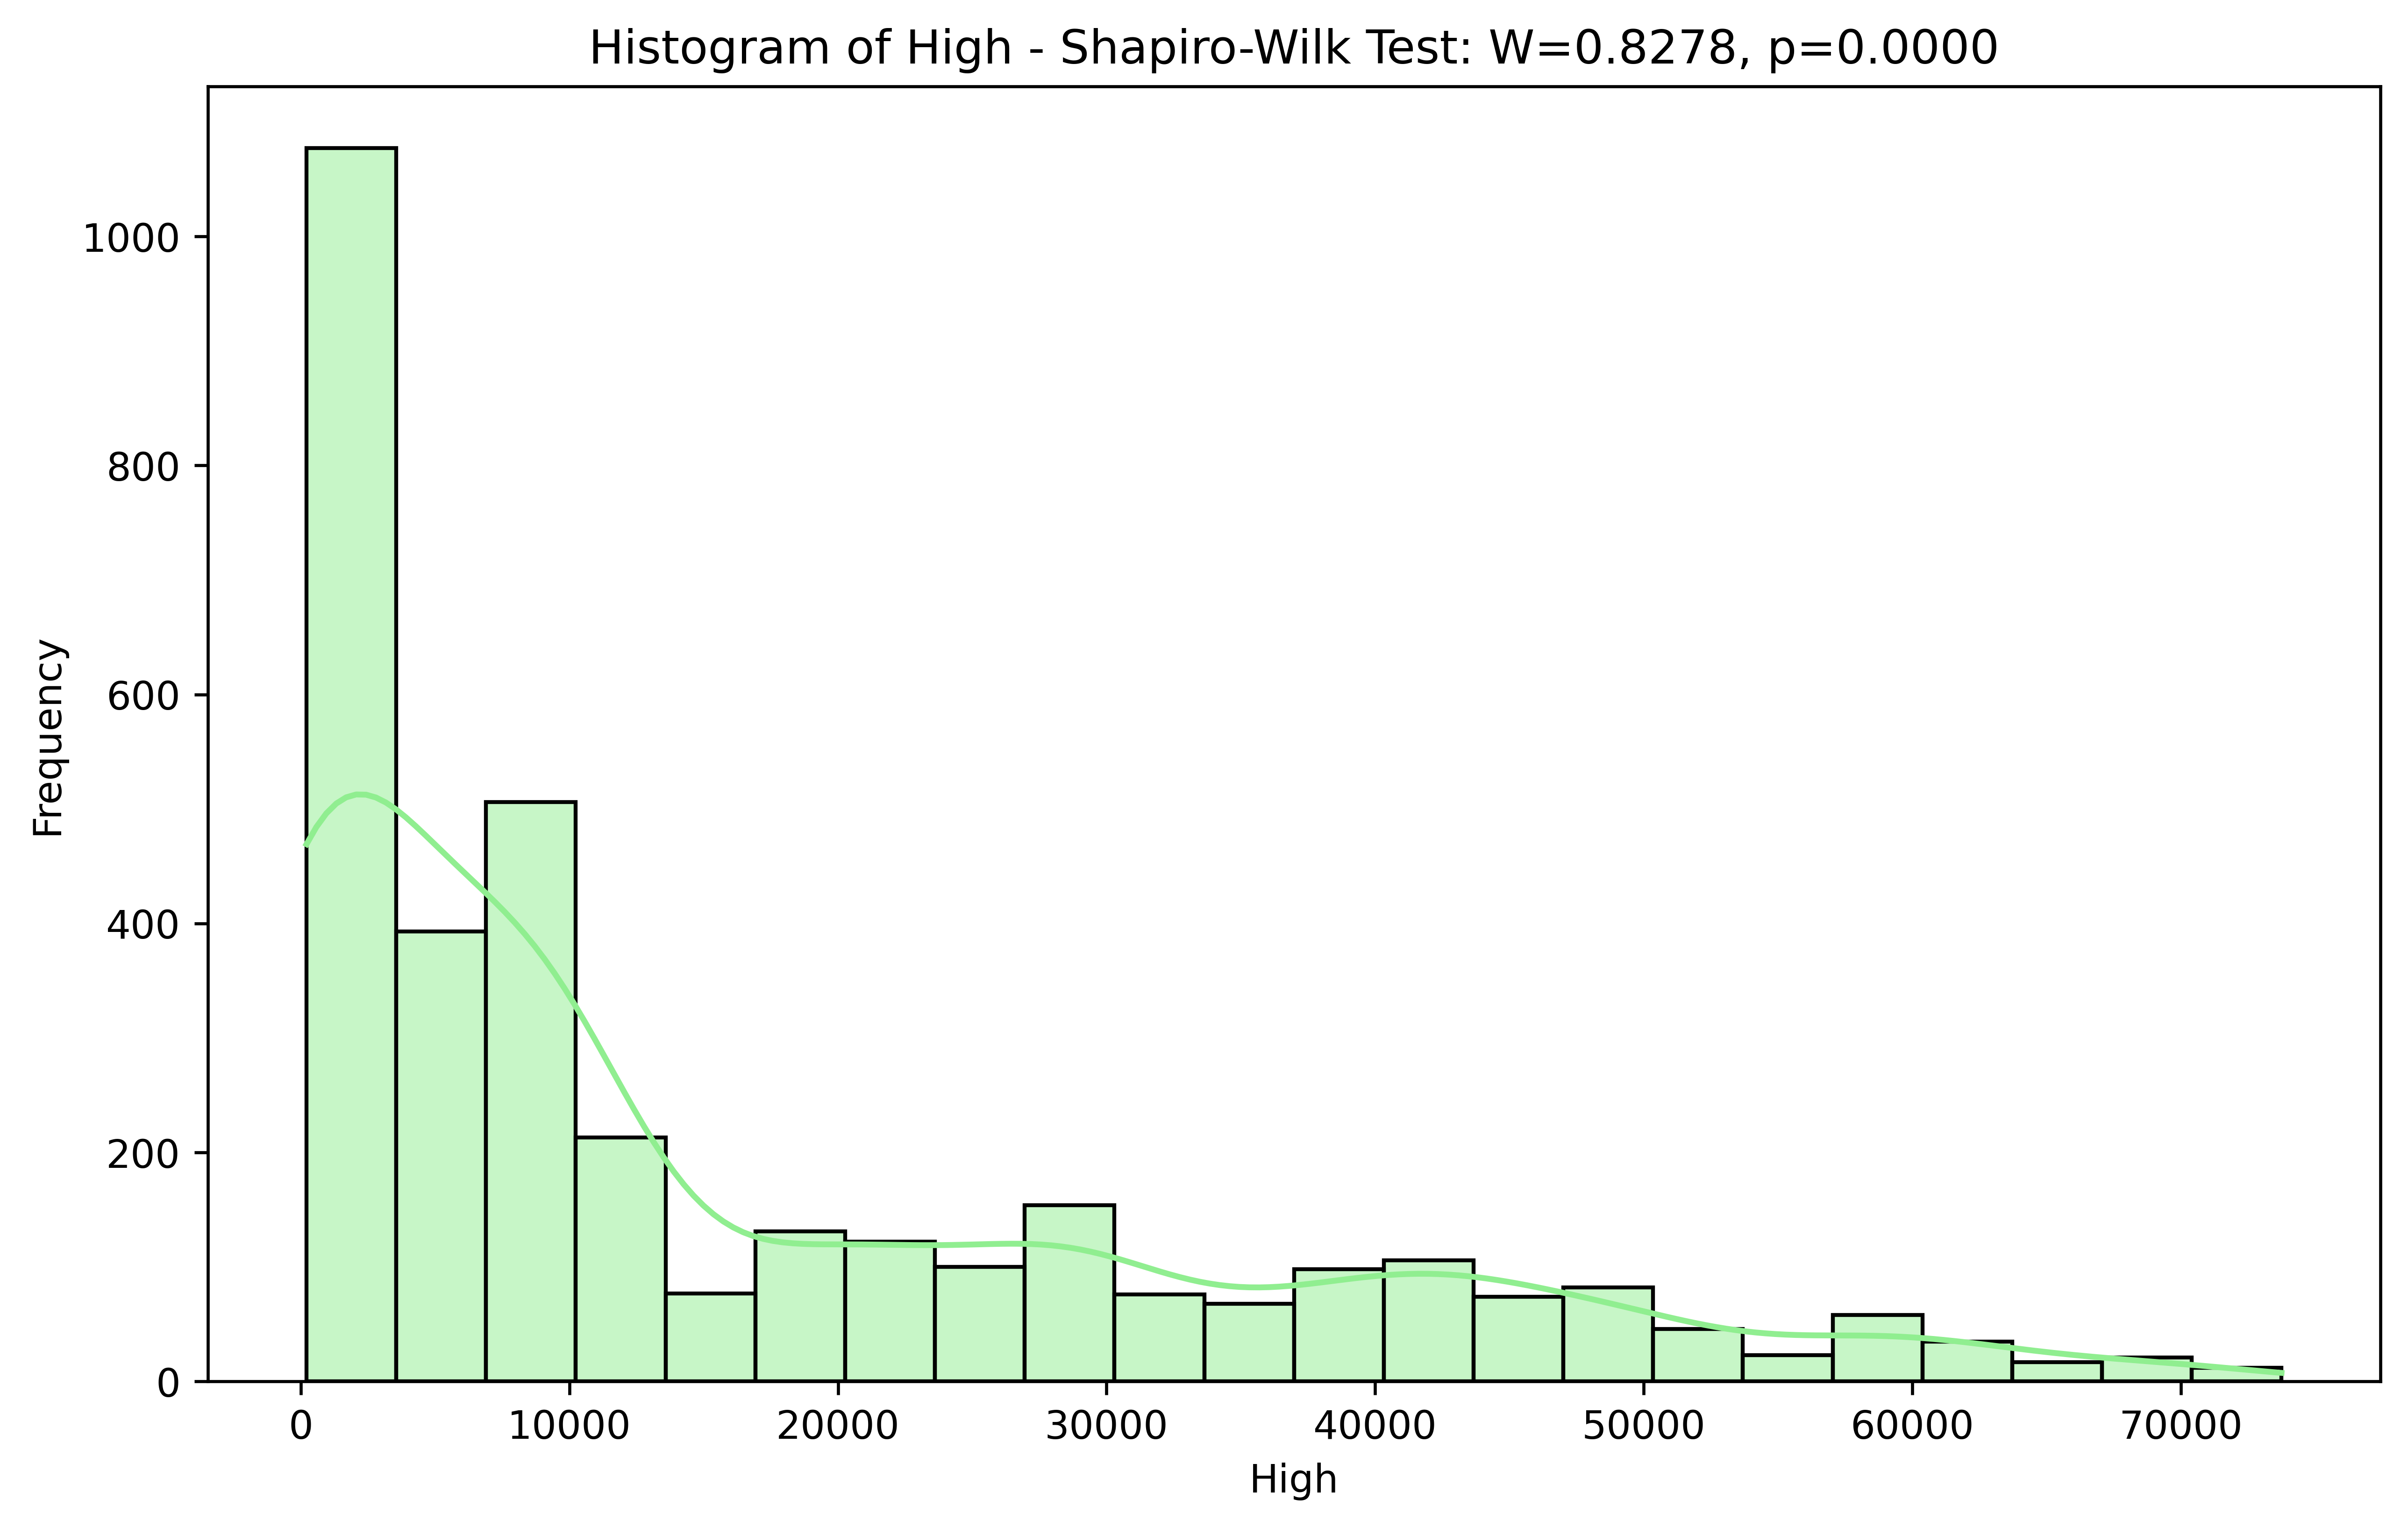

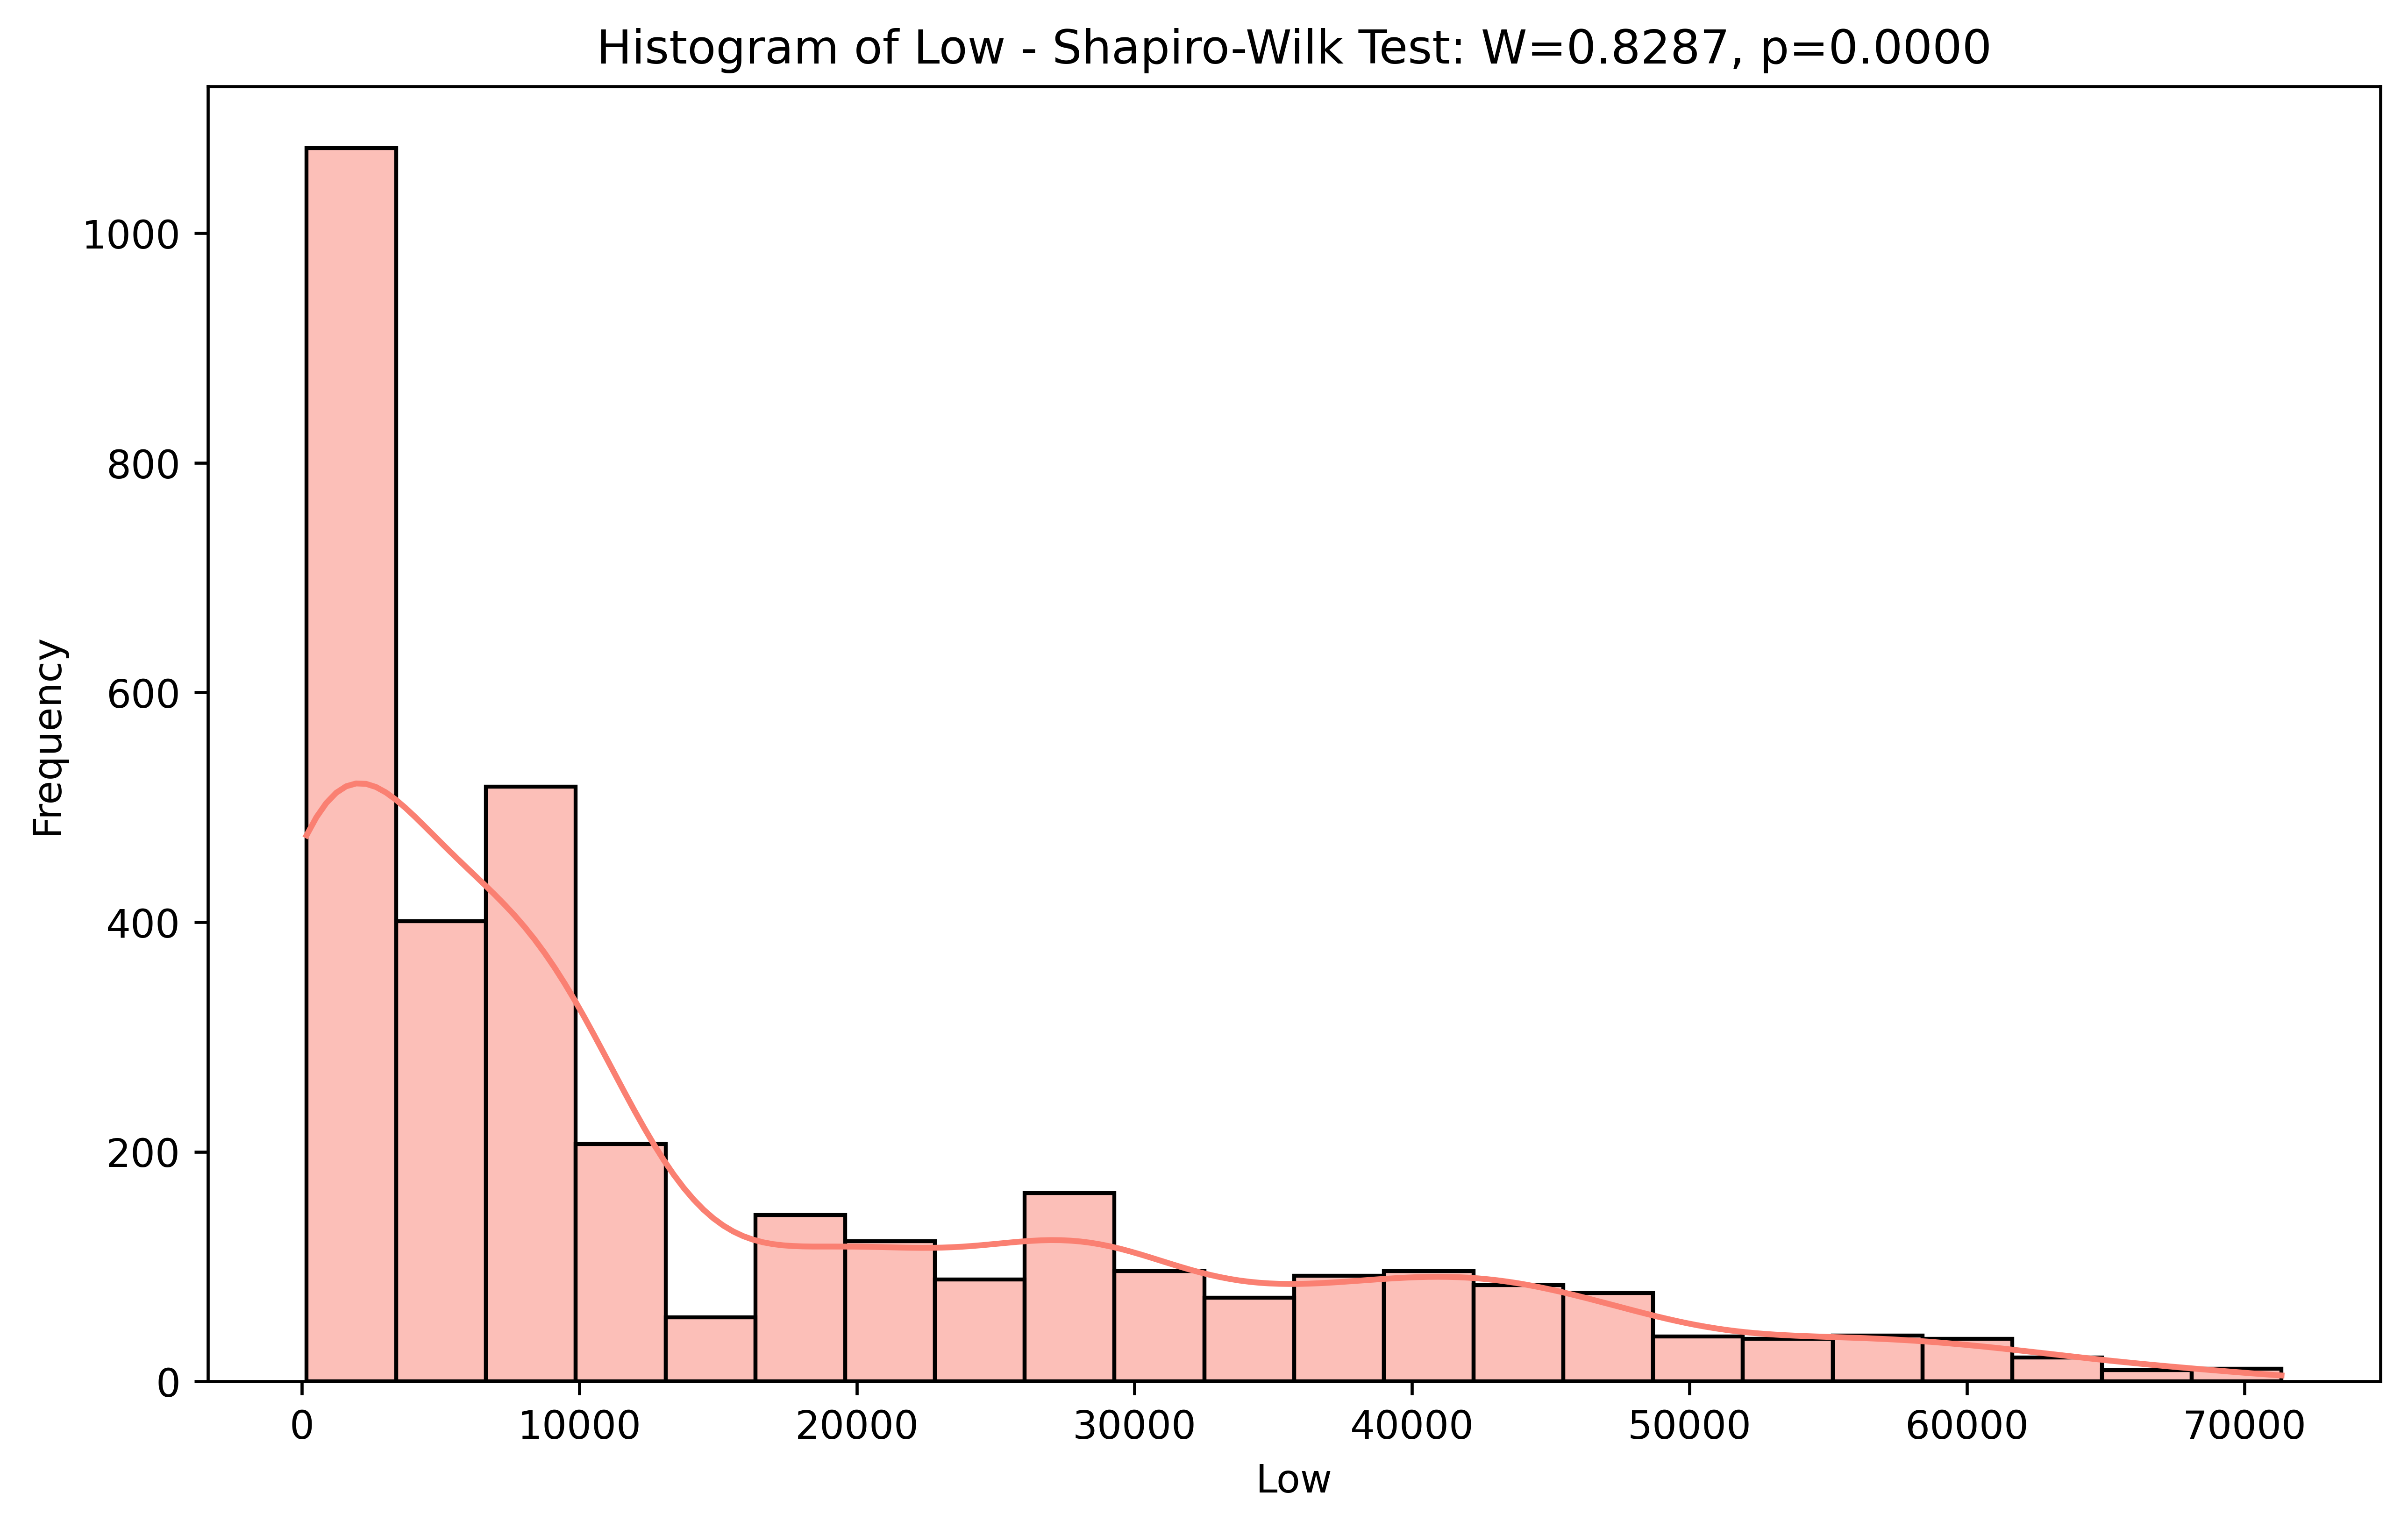

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def shapiro_test(data, column):
    """ 进行 Shapiro-Wilk 测试并返回结果 """
    stat, p_value = stats.shapiro(data[column].dropna())  # 去除NaN值
    return f"Shapiro-Wilk Test: W={stat:.4f}, p={p_value:.4f}"

def plot_histogram(data, column, color):
    """ 绘制直方图并标注 Shapiro-Wilk 测试结果 """
    plt.figure(figsize=(10, 6), dpi=600)
    sns.histplot(data[column], kde=True, color=color)
    plt.title(f'Histogram of {column} - {shapiro_test(data, column)}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# 假设 df 是你的 DataFrame
colors = ['skyblue', 'lightgreen', 'salmon']  # 为每个直方图指定不同的颜色
columns = ['Open', 'High', 'Low']
for col, color in zip(columns, colors):
    plot_histogram(df, col, color)

plt.show()

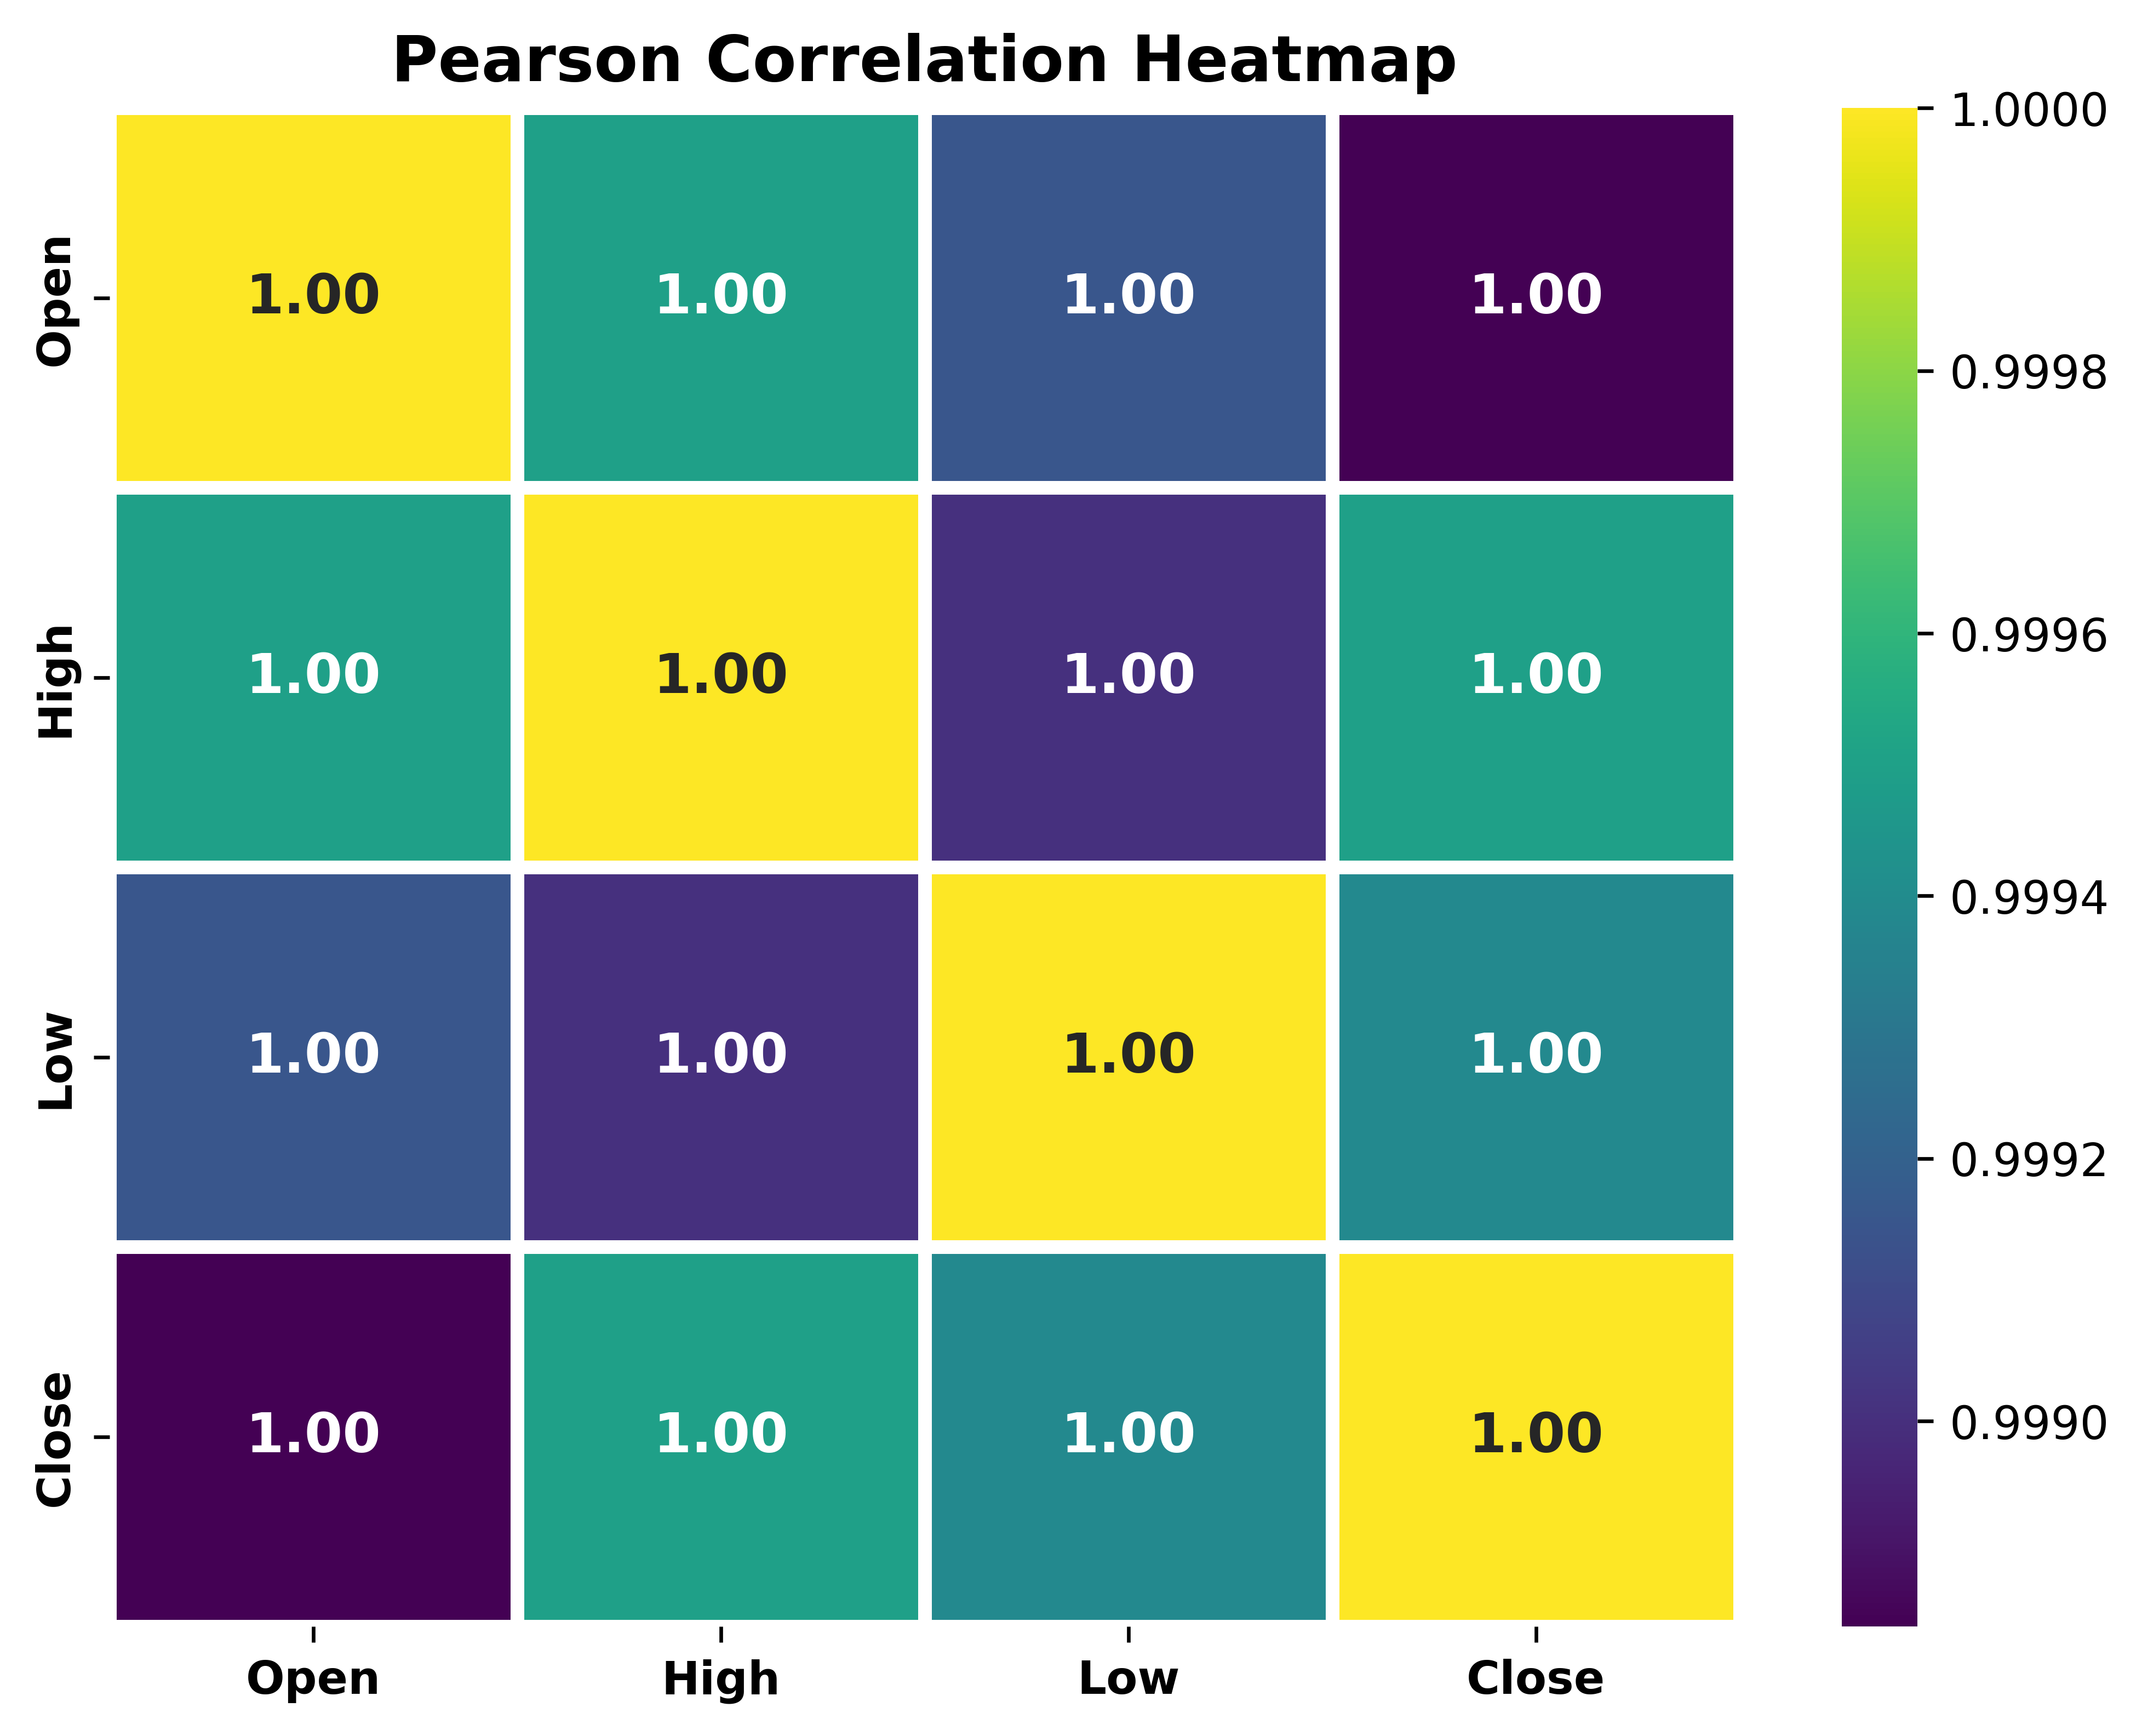

In [25]:
def calculate_pearson_correlation(data, columns):
    """ 计算指定列的 Pearson 相关系数 """
    correlation_matrix = data[columns].corr()
    return correlation_matrix

def plot_correlation_heatmap(correlation_matrix):
    """ 绘制优化后的相关系数热力图 """
    plt.figure(figsize=(8, 6), dpi=600)  # 设置图像大小和DPI
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f",
                linewidths=3,  # 增加格子之间的间距
                annot_kws={"size": 12, "weight": "bold"})  # 增加格子中数字的字体大小和加粗
    plt.title('Pearson Correlation Heatmap', fontsize=14, weight='bold')
    plt.xticks(fontsize=10, weight='bold')
    plt.yticks(fontsize=10, weight='bold')
    plt.show()

# 假设 df 是你的 DataFrame，包含 'Open', 'High', 'Low', 'Close' 列
# columns = ['Open', 'High', 'Low', 'Close']
columns = columns_list

# 计算 Pearson 相关系数
correlation_matrix = calculate_pearson_correlation(df, columns)

# 绘制热力图
plot_correlation_heatmap(correlation_matrix)

## 2. 数据预处理与特征工程

In [4]:
def enhance_features(df):
    # 确保索引是日期类型
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)

    # 添加日期特征
    df['Day_of_Year'] = df.index.dayofyear
    df['Week_of_Year'] = df.index.isocalendar().week
    df['Day_of_Week'] = df.index.dayofweek

    # 计算移动平均线和指数移动平均线
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['EMA5'] = df['Close'].ewm(span=5, adjust=False).mean()

    # 滚动窗口大小
    window_sizes = [3, 7, 14, 30]

    # 为每个窗口大小生成滚动特征
    for window in window_sizes:
        df[f'Open_Rolling_Mean_{window}'] = df['Open'].rolling(window=window).mean()
        df[f'High_Rolling_Max_{window}'] = df['High'].rolling(window=window).max()
        df[f'Low_Rolling_Min_{window}'] = df['Low'].rolling(window=window).min()
        df[f'Close_Rolling_Std_{window}'] = df['Close'].rolling(window=window).std()

        # 指数移动平均线（EMA）
        df[f'Close_EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

        # 相对强弱指数（RSI）
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    # 计算MACD和信号线
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    #signal = macd.ewm(span=9, adjust=False).mean()
    df['MACD'] = macd
    #df['Signal'] = signal

    # 添加滞后特征
    df['Lag1'] = df['Close'].shift(1)
    df['Lag2'] = df['Close'].shift(2)

    # 添加窗口统计
    # df['max2'] = df['Close'].rolling(window=2).max()
    # df['min2'] = df['Close'].rolling(window=2).min()
    # df['mean2'] = df['Close'].rolling(window=2).mean()
    # df['std2'] = df['Close'].rolling(window=2).std()

    # 删除任何由于滚动统计而产生的NA值
    df.dropna(inplace=True)
    df.drop(columns=["Adj Close","Volume"], inplace=True)

    return df

In [5]:
data_after = enhance_features(data)

In [6]:
data_after

,Open,High,Low,Close,Day_of_Year,Week_of_Year,Day_of_Week,MA5,MA10,EMA5,...,RSI_14,Open_Rolling_Mean_30,High_Rolling_Max_30,Low_Rolling_Min_30,Close_Rolling_Std_30,Close_EMA_30,RSI_30,MACD,Lag1,Lag2
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-16,394.518005,398.807007,373.070007,382.556000,289,42,3,389.432403,372.517606,385.146292,...,52.336359,386.871267,468.174011,289.295990,32.045785,387.667827,39.827114,-7.086205,394.773010,400.869995
2014-10-17,382.756012,385.477997,375.389008,383.757996,290,42,4,390.474200,377.274704,384.683526,...,58.314477,384.101000,456.859985,289.295990,28.910903,387.415580,40.023263,-6.039892,382.556000,394.773010
2014-10-18,383.976013,395.157990,378.971008,391.441986,291,42,5,390.679797,381.124902,386.936346,...,75.469711,381.671534,441.557007,289.295990,27.834889,387.675348,45.197185,-4.538333,383.757996,382.556000
2014-10-19,391.253998,393.938995,386.457001,389.545990,292,42,6,388.414996,383.576901,387.806228,...,79.658723,380.576568,441.557007,289.295990,27.758701,387.796034,49.168725,-3.461426,391.441986,383.757996
2014-10-20,389.230988,390.084015,378.252014,382.845001,293,43,0,386.029395,385.705200,386.152485,...,73.241668,380.395167,441.557007,289.295990,27.238360,387.476613,45.774759,-3.112802,389.545990,391.441986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,71333.484375,71342.093750,68110.695313,69702.148438,92,14,0,70263.776563,69201.725000,69992.085447,...,53.815343,67876.303125,73750.070313,59323.910156,2863.107821,66355.606552,56.257429,2033.214116,71333.648438,69645.304688
2024-04-02,69705.023438,69708.382813,64586.593750,65446.972656,93,14,1,69204.180469,69340.201953,68477.047850,...,56.583423,68132.084636,73750.070313,59323.910156,2754.968124,66296.985010,51.769240,1590.495851,69702.148438,71333.648438
2024-04-03,65446.671875,66914.320313,64559.898438,65980.812500,94,14,2,68421.777344,69214.866016,67644.969400,...,45.478606,68209.073568,73750.070313,59323.910156,2784.652111,66276.586784,48.035253,1268.097018,65446.972656,69702.148438


In [34]:
columns_list = [col for col in data_after.columns]

In [35]:
columns_list

['Open',
 'High',
 'Low',
 'Close',
 'Day_of_Year',
 'Week_of_Year',
 'Day_of_Week',
 'MA5',
 'MA10',
 'EMA5',
 'Open_Rolling_Mean_3',
 'High_Rolling_Max_3',
 'Low_Rolling_Min_3',
 'Close_Rolling_Std_3',
 'Close_EMA_3',
 'RSI_3',
 'Open_Rolling_Mean_7',
 'High_Rolling_Max_7',
 'Low_Rolling_Min_7',
 'Close_Rolling_Std_7',
 'Close_EMA_7',
 'RSI_7',
 'Open_Rolling_Mean_14',
 'High_Rolling_Max_14',
 'Low_Rolling_Min_14',
 'Close_Rolling_Std_14',
 'Close_EMA_14',
 'RSI_14',
 'Open_Rolling_Mean_30',
 'High_Rolling_Max_30',
 'Low_Rolling_Min_30',
 'Close_Rolling_Std_30',
 'Close_EMA_30',
 'RSI_30',
 'MACD',
 'Lag1',
 'Lag2']

In [20]:
temp1 = ['High_Rolling_Max_30','Low_Rolling_Min_30','MACD','RSI_3','RSI_7','Close']

In [9]:
# 计算相关性矩阵
correlation_matrix = data_after.corr()

# 提取与 'Close' 列相关的相关性系数
close_correlations = correlation_matrix['Close']

# 剔除相关性系数的绝对值大于0.95的特征
# filtered_correlations = close_correlations[(close_correlations != 1) & (close_correlations != -1)]
filtered_correlations = close_correlations[(close_correlations.abs() <= 0.99)]

# 对相关性系数按绝对值大小降序排列，并选择相关性最强的6个特征
top_features = filtered_correlations.abs().sort_values(ascending=False)

# 输出结果
print("Top 6 features most correlated with 'Close' (excluding correlations > 0.95):")
print(top_features)

Top 6 features most correlated with 'Close' (excluding correlations > 0.95):
High_Rolling_Max_30     0.988812
Open_Rolling_Mean_30    0.986863
Low_Rolling_Min_30      0.982801
Close_Rolling_Std_30    0.813449
Close_Rolling_Std_14    0.800525
Close_Rolling_Std_7     0.783820
Close_Rolling_Std_3     0.700108
MACD                    0.292938
Week_of_Year            0.071988
Day_of_Year             0.070894
RSI_30                  0.037655
RSI_14                  0.014582
RSI_3                   0.012871
RSI_7                   0.006042
Day_of_Week             0.001495
Name: Close, dtype: float64


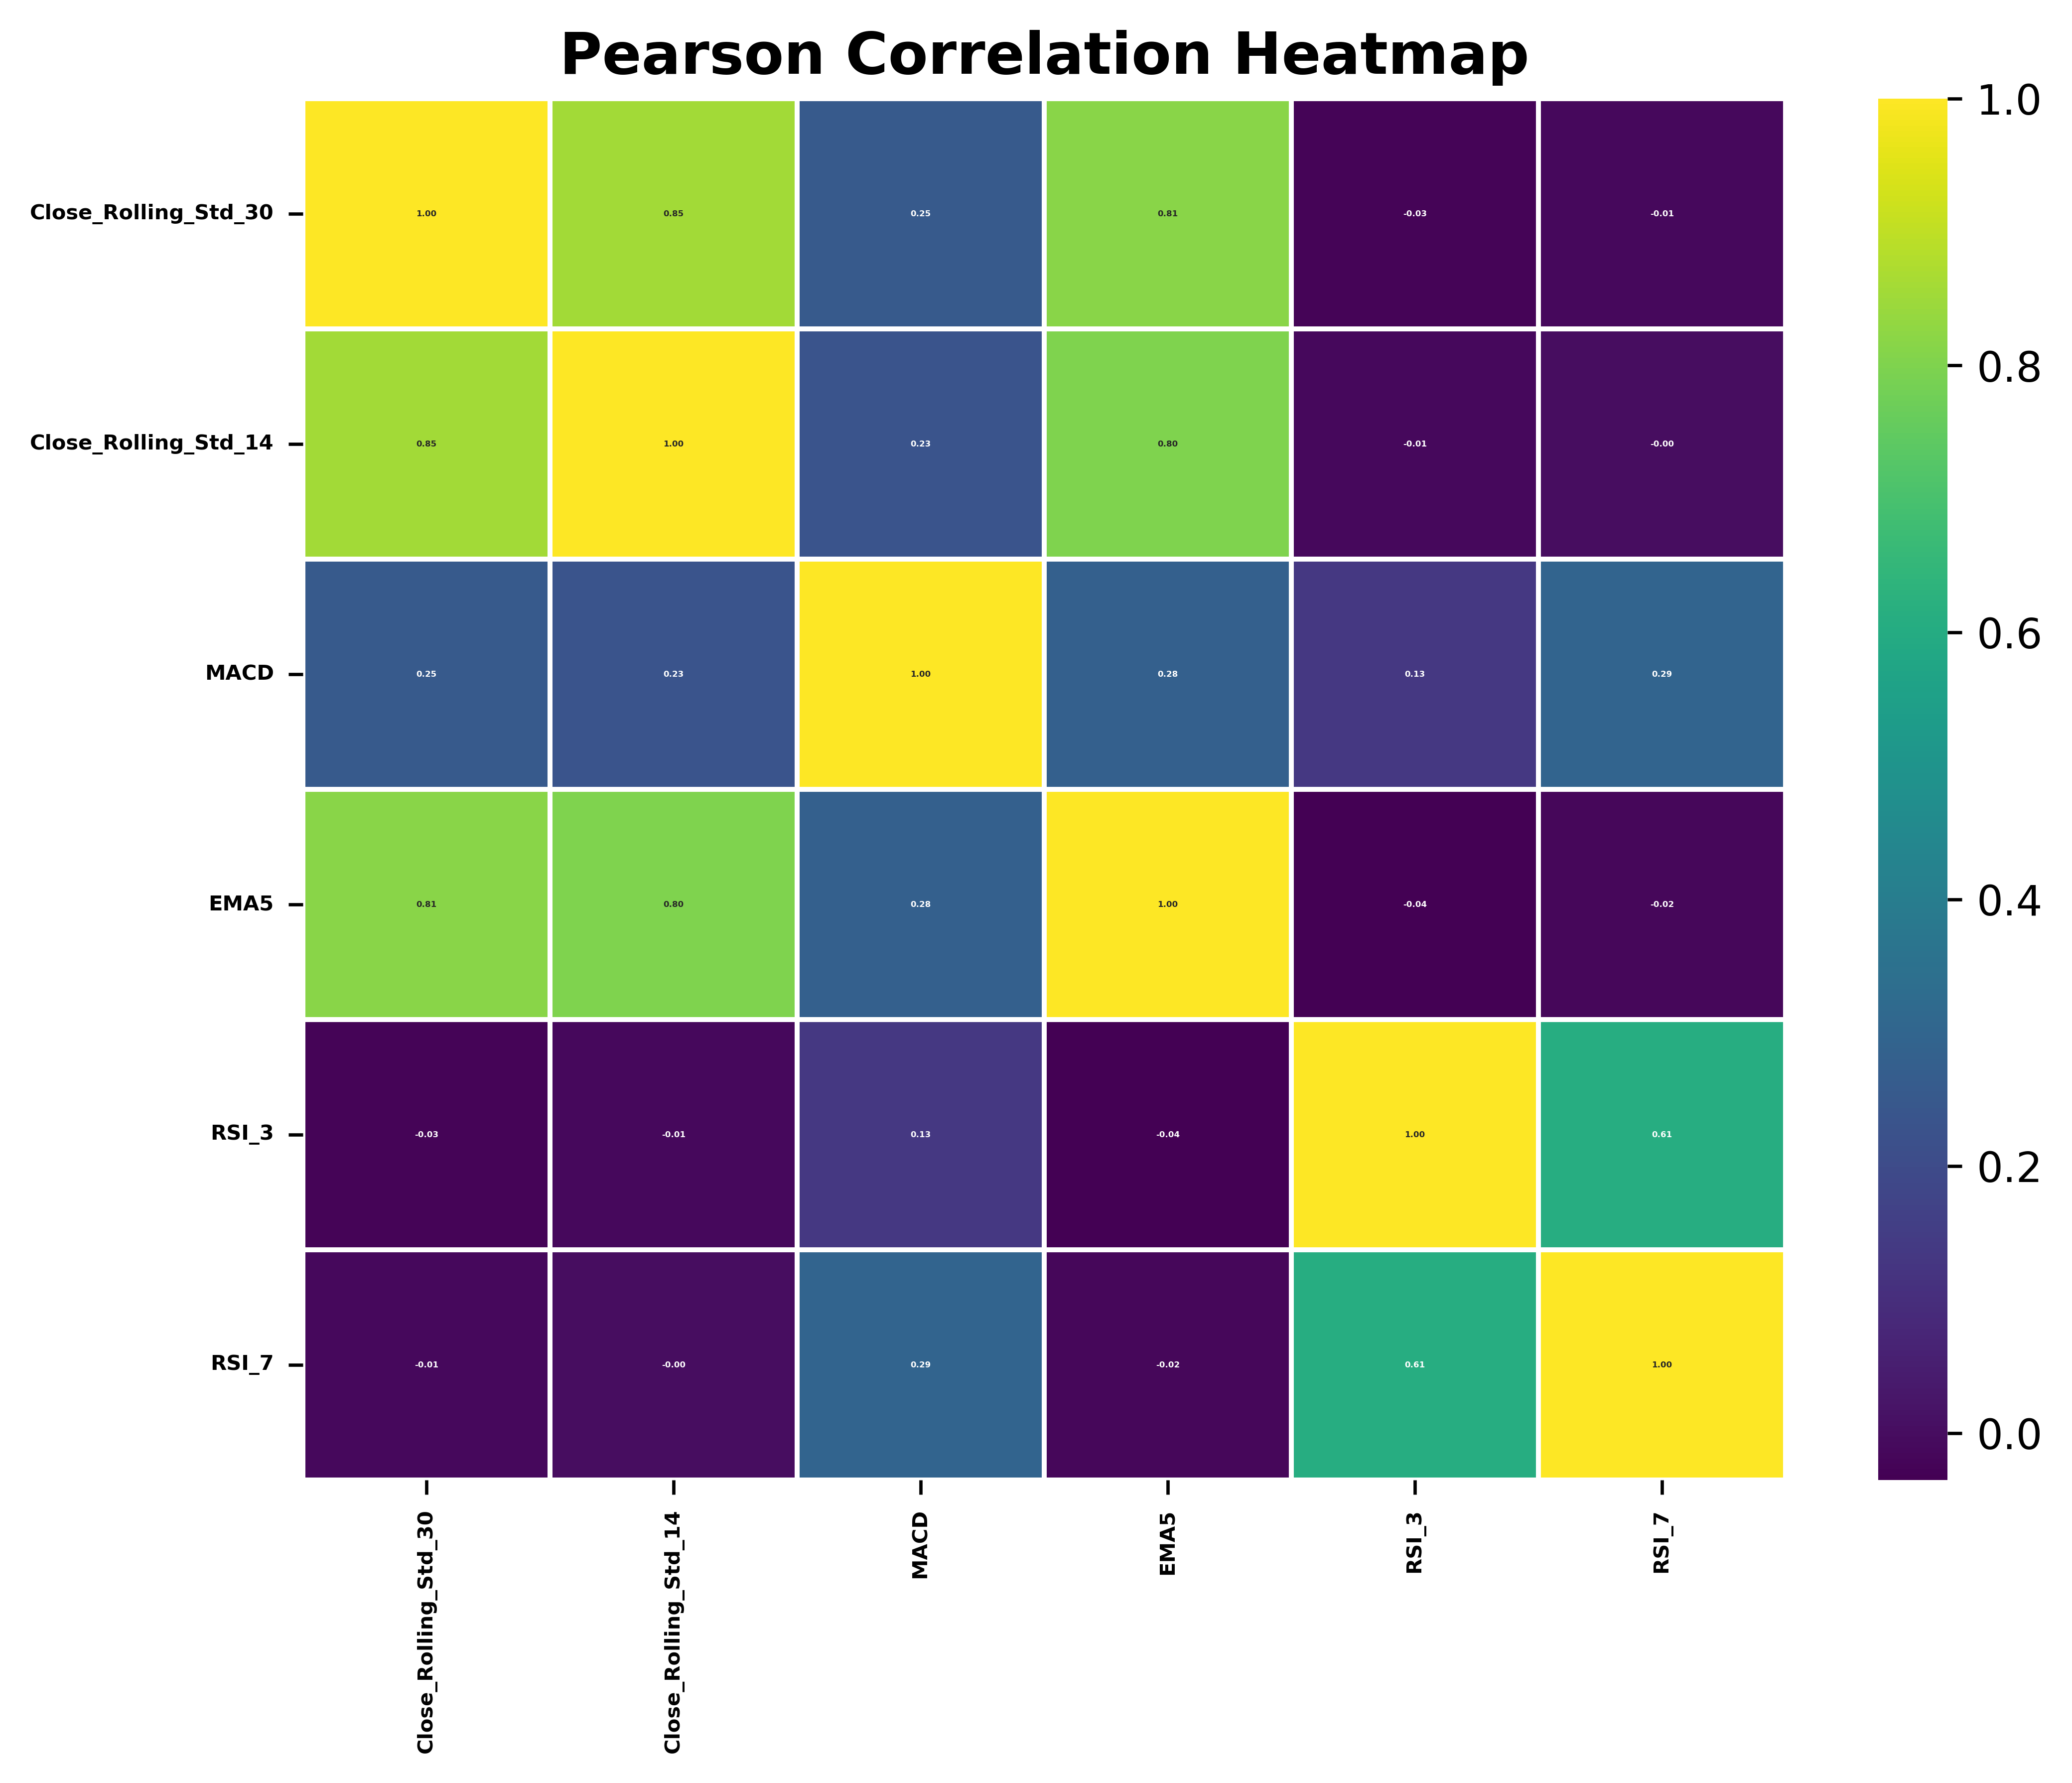

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_pearson_correlation(data, columns):
    """ 计算指定列的 Pearson 相关系数 """
    correlation_matrix = data[columns].corr()
    return correlation_matrix

def plot_correlation_heatmap(correlation_matrix):
    """ 绘制优化后的相关系数热力图 """
    plt.figure(figsize=(8, 6), dpi=600)  # 设置图像大小和DPI
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f",
                linewidths=1,  # 增加格子之间的间距
                annot_kws={"size": 2, "weight": "bold"})  # 增加格子中数字的字体大小和加粗
    plt.title('Pearson Correlation Heatmap', fontsize=14, weight='bold')
    plt.xticks(fontsize=5, weight='bold')
    plt.yticks(fontsize=5, weight='bold')
    plt.show()

columns = temp1

# 计算 Pearson 相关系数
correlation_matrix = calculate_pearson_correlation(data_after, columns)

# 绘制热力图
plot_correlation_heatmap(correlation_matrix)

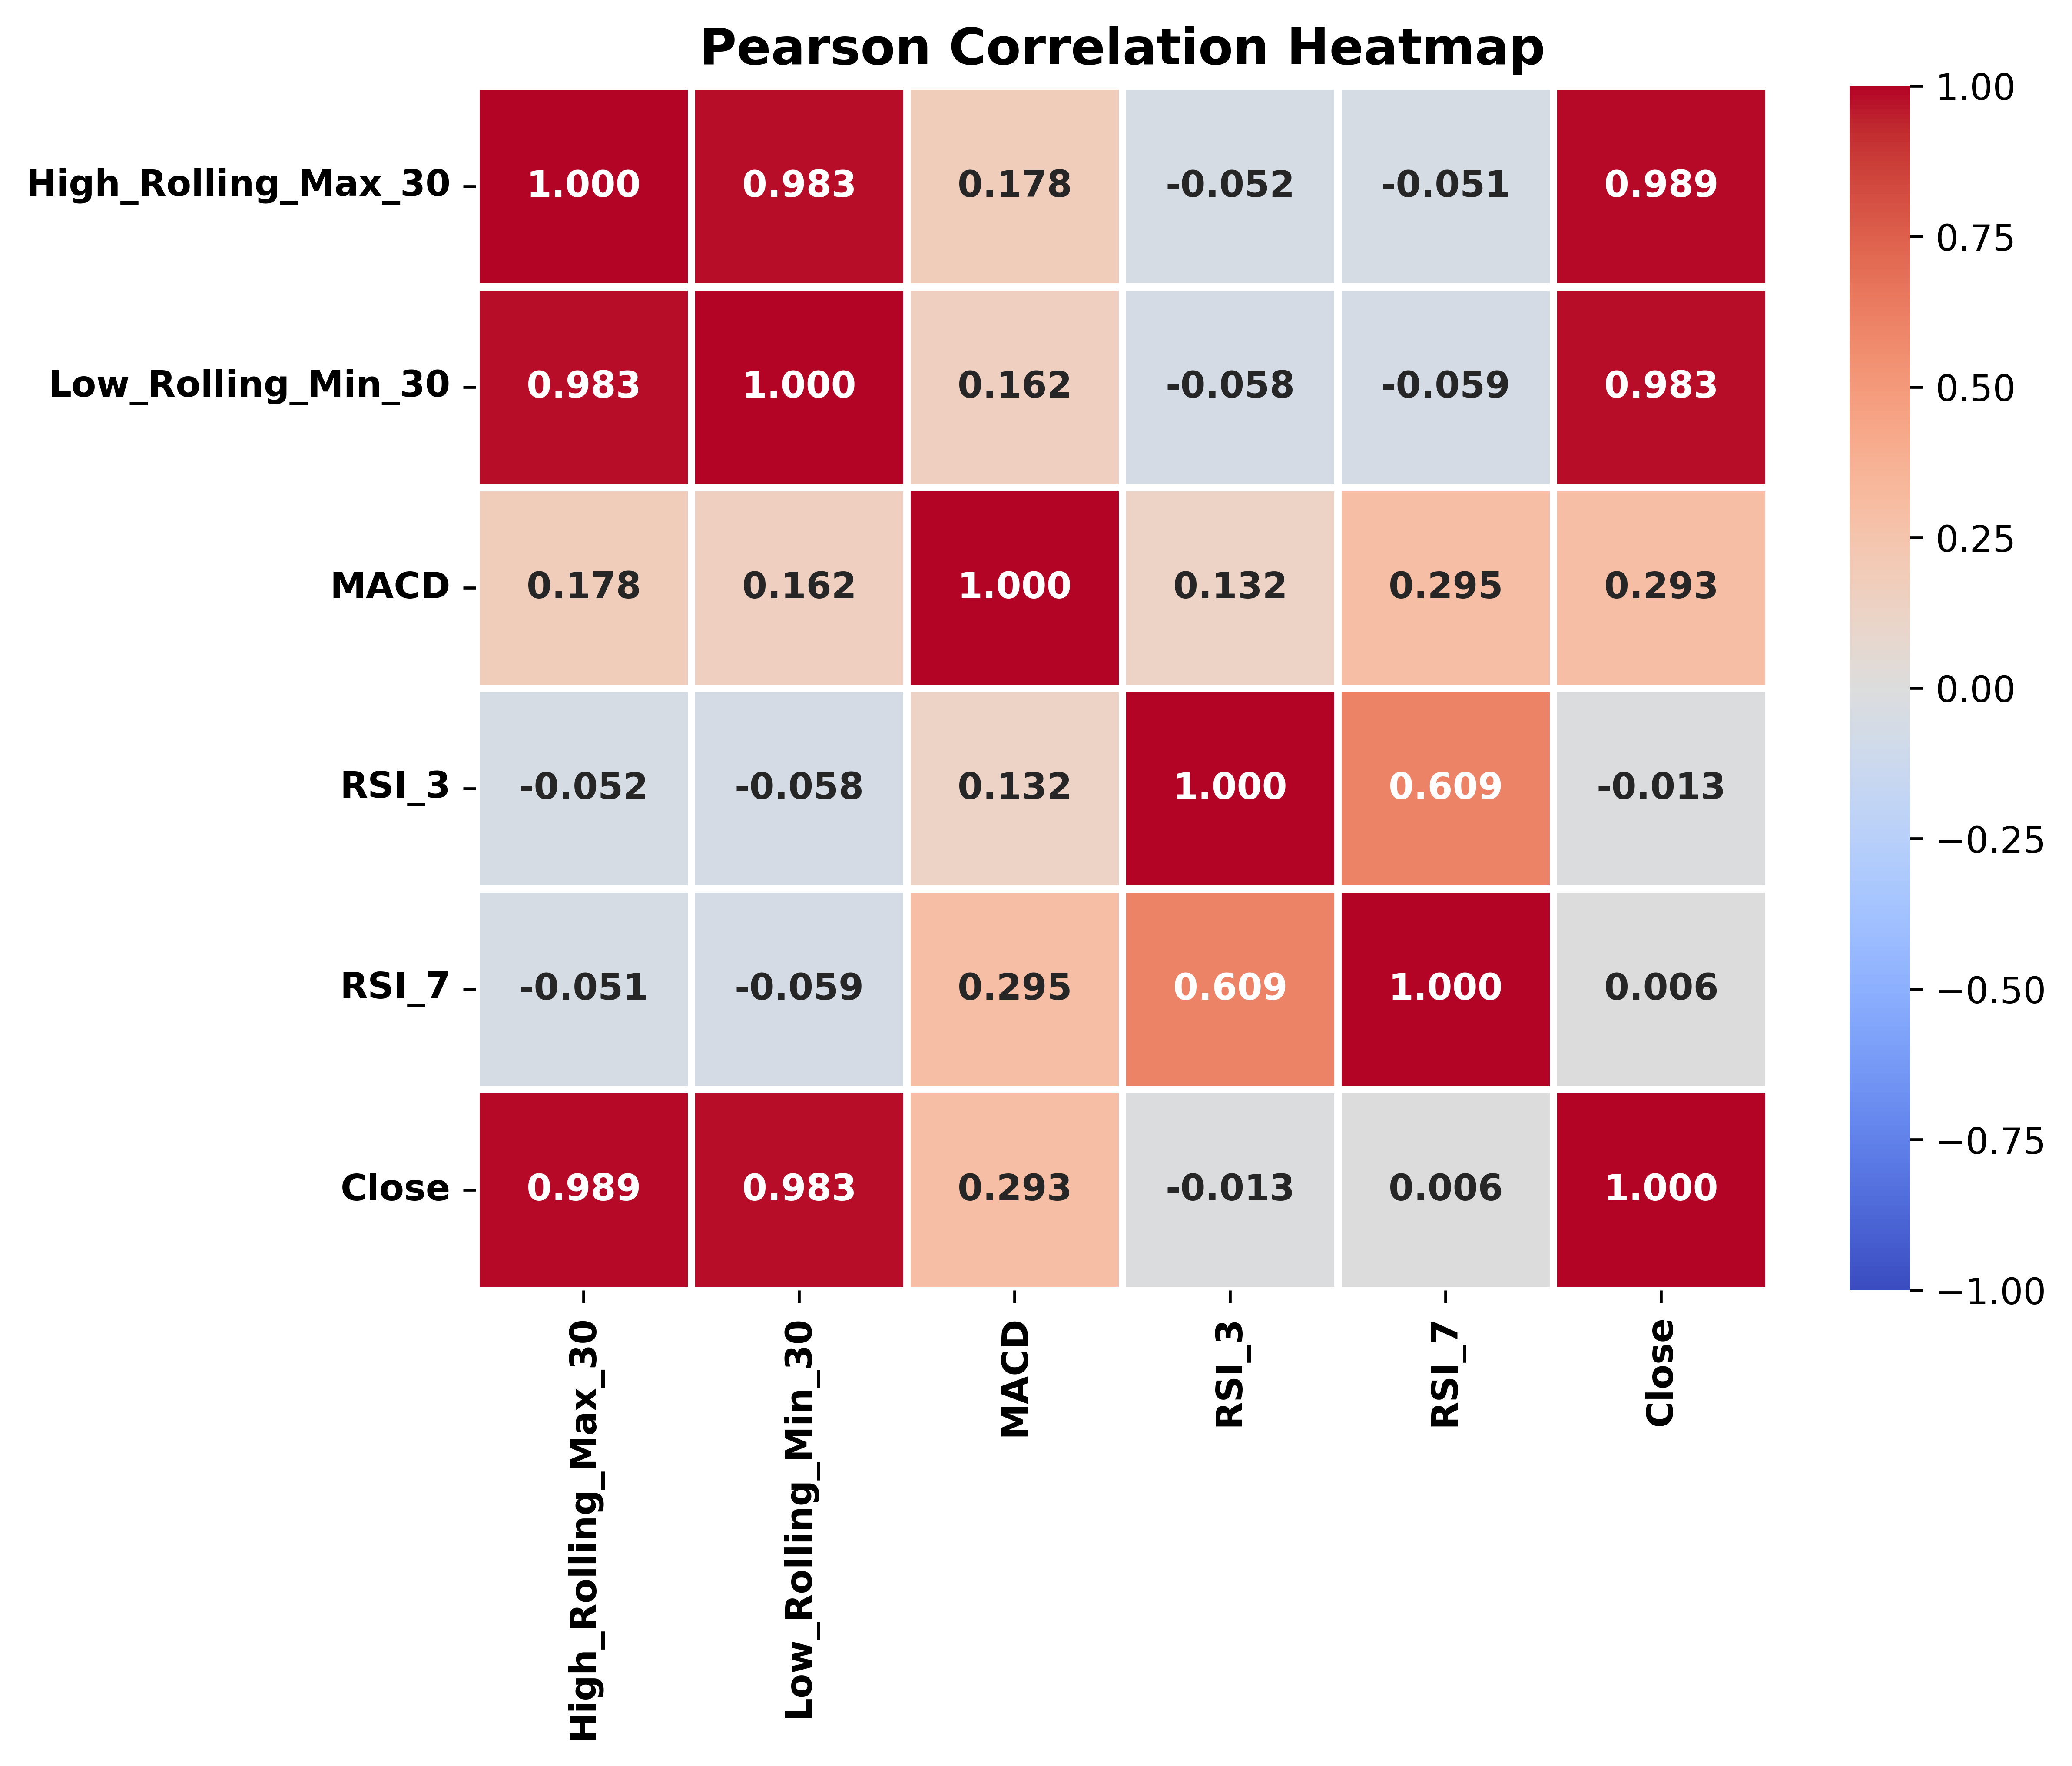

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_pearson_correlation(data, columns):
    """计算指定列的 Pearson 相关系数"""
    correlation_matrix = data[columns].corr()
    return correlation_matrix

def plot_correlation_heatmap(correlation_matrix):
    """绘制优化后的相关系数热力图"""
    plt.figure(figsize=(8, 6), dpi=600)  # 设置图像大小和DPI
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f",
                linewidths=2,  # 增加格子之间的间距
                annot_kws={"size": 10, "weight": "bold"},  # 调整格子中数字的字体大小和加粗
                vmin=-1, vmax=1)  # 设置色阶条的范围
    plt.title('Pearson Correlation Heatmap', fontsize=14, weight='bold')
    plt.xticks(fontsize=10, weight='bold')  # 调整刻度字体大小和加粗
    plt.yticks(fontsize=10, weight='bold')  # 调整刻度字体大小和加粗
    plt.show()

# 假设 temp1 是你想分析的列名列表
columns = temp1

# 计算 Pearson 相关系数
correlation_matrix = calculate_pearson_correlation(data_after, columns)

# 绘制热力图
plot_correlation_heatmap(correlation_matrix)

## 3. 划分数据集

In [39]:
# 获取最后一个月的数据作为测试集
last_date = data_after.index.max()
one_month_ago = last_date - pd.DateOffset(months=1)

# 分割数据集
train_data = data_after[data_after.index <= one_month_ago]
test_data = data_after[data_after.index > one_month_ago]

# 将特征和标签分开
X_train = train_data.drop(['Close'], axis=1)  # 删除标签列
X_train = X_train.astype(np.float32)

y_train = train_data['Close']

X_test = test_data.drop(['Close'], axis=1)
X_test = X_test.astype(np.float32)

y_test = test_data['Close']

# 打印结果以验证分割是否正确
print(f"训练集特征形状: {X_train.shape}, 训练集标签长度: {y_train.shape}")
print(f"测试集特征形状: {X_test.shape}, 测试集标签长度: {y_test.shape}")

训练集特征形状: (3429, 36), 训练集标签长度: (3429,)
测试集特征形状: (31, 36), 测试集标签长度: (31,)


In [40]:
columns_list = data_after.columns.tolist()

filtered_columns = [column for column in columns_list if column != 'Close']

## 4. Transformer模型

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
def load_data(X_train, y_train, X_test, y_test):
    # 转为Tensor
    X_train = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    # 创建DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader

# 定义Transformer模型
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=input_dim, nhead=num_heads,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers,
                                          dropout=dropout)
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, src):
        # Transformer需要src的形状为 (seq_length, batch_size, features)
        src = src.permute(1, 0, 2)
        output = self.transformer(src, src)
        output = output.permute(1, 0, 2)
        return self.linear(output[:, -1, :])

# 训练模型
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

# 测试模型
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            predictions.extend(output.squeeze().tolist())
            actuals.extend(y_batch.tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

    return predictions


train_loader, test_loader = load_data(X_train, y_train, X_test, y_test)

model = TimeSeriesTransformer(input_dim=36, num_heads=4, num_layers=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练和测试
train_model(model, train_loader, criterion, optimizer, num_epochs=500)
tf_res = evaluate_model(model, test_loader)

Epoch 1, Loss: 513255445.9259259
Epoch 2, Loss: 514423697.1851852
Epoch 3, Loss: 511865614.8148148
Epoch 4, Loss: 513321561.4814815
Epoch 5, Loss: 515690113.4814815
Epoch 6, Loss: 513258317.6296296
Epoch 7, Loss: 510988286.2222222
Epoch 8, Loss: 511959416.8888889
Epoch 9, Loss: 511751205.9259259
Epoch 10, Loss: 512181431.1111111
Epoch 11, Loss: 510722789.3333333
Epoch 12, Loss: 511698786.3703704
Epoch 13, Loss: 510055473.7777778
Epoch 14, Loss: 510599879.1111111
Epoch 15, Loss: 510026146.6666667
Epoch 16, Loss: 509608669.037037
Epoch 17, Loss: 509304142.2222222
Epoch 18, Loss: 508215294.2222222
Epoch 19, Loss: 507218611.5555556
Epoch 20, Loss: 504618207.4074074
Epoch 21, Loss: 505931133.037037
Epoch 22, Loss: 504877362.962963
Epoch 23, Loss: 505425317.6296296
Epoch 24, Loss: 504613707.2592593
Epoch 25, Loss: 503622610.3703704
Epoch 26, Loss: 502406240.0
Epoch 27, Loss: 502077056.0
Epoch 28, Loss: 502481392.8888889
Epoch 29, Loss: 499023043.5555556
Epoch 30, Loss: 499007304.2962963
Epoc

In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_model(predictions, y_test):
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    return mse, rmse, mae

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# 训练模型并评估
model_results = {}

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train_scaled, y_train)
xgb_predictions = xgb_model.predict(X_test_scaled)
model_results['XGBoost'] = evaluate_model(xgb_predictions, y_test)

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=1000)
lgb_model.fit(X_train_scaled, y_train)
lgb_predictions = lgb_model.predict(X_test_scaled)
model_results['LightGBM'] = evaluate_model(lgb_predictions, y_test)

# CatBoost
cb_model = cb.CatBoostRegressor(iterations=1000, verbose=False, task_type='GPU')
cb_model.fit(X_train_scaled, y_train)
cb_predictions = cb_model.predict(X_test_scaled)
model_results['CatBoost'] = evaluate_model(cb_predictions, y_test)

# LSTM
X_train_3d = np.array(X_train_scaled)[:, None, :]
X_test_3d = np.array(X_test_scaled)[:, None, :]

y_train_np = np.array(y_train)[:, None]

# 创建 TensorDataset
train_data = TensorDataset(torch.tensor(X_train_3d.astype(np.float32)), torch.tensor(y_train_np.astype(np.float32)))

# 创建 DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
lstm_model = LSTMModel(input_dim=X_train_scaled.shape[1], hidden_dim=100, num_layers=3, output_dim=1)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# 训练过程
num_epochs = 1000
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

# 预测和评估
lstm_predictions = lstm_model(torch.tensor(X_test_3d.astype(np.float32)))
lstm_predictions = lstm_predictions.detach().numpy()
model_results['LSTM'] = evaluate_model(lstm_predictions, y_test)

# 输出结果
for model_name, scores in model_results.items():
    print(f"{model_name}: MSE={scores[0]:.4f}, RMSE={scores[1]:.4f}, MAE={scores[2]:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8731
[LightGBM] [Info] Number of data points in the train set: 3429, number of used features: 36
[LightGBM] [Info] Start training from score 15329.802146


XGBoost: MSE=14513795.6530, RMSE=3809.6976, MAE=3217.0297
LightGBM: MSE=19145016.0656, RMSE=4375.5018, MAE=3862.2423
CatBoost: MSE=22866728.2357, RMSE=4781.9168, MAE=4328.7929
LSTM: MSE=4120718774.8906, RMSE=64192.8249, MAE=64140.7429


In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

X = data_after.drop('Close', axis=1).values
y = data_after['Close'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


def evaluate_model(predictions, y_test):
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    return mse, rmse, mae


kf = KFold(n_splits=5, random_state=42, shuffle=True)

model_results = {
'XGBoost': [],
'LightGBM': [],
'CatBoost': [],
}

best_models = {}

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]


# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
model_results['XGBoost'].append(evaluate_model(xgb_predictions, y_test))

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=1000)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
model_results['LightGBM'].append(evaluate_model(lgb_predictions, y_test))

# CatBoost
cb_model = cb.CatBoostRegressor(iterations=1000, verbose=False,task_type='GPU')
cb_model.fit(X_train, y_train)
cb_predictions = cb_model.predict(X_test)
model_results['CatBoost'].append(evaluate_model(cb_predictions, y_test))

best_scores = {key: min(models, key=lambda x: x[1]) for key, models in model_results.items()} # 假设我们关注的是RMSE

for model_name, scores in best_scores.items():
    print(f"Best {model_name}: MSE={scores[0]:.4f}, RMSE={scores[1]:.4f}, MAE={scores[2]:.4f}")

xgb_model.save_model('xgb_model.json')
lgb_model.booster_.save_model('lgb_model.txt')
cb_model.save_model('cb_model.cbm')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8716
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 36
[LightGBM] [Info] Start training from score 15697.415188


Best XGBoost: MSE=291637.6280, RMSE=540.0348, MAE=264.3424
Best LightGBM: MSE=138934.8153, RMSE=372.7396, MAE=189.6336
Best CatBoost: MSE=265721.5100, RMSE=515.4818, MAE=289.8482


回归方程为: y = 3139.47 + 0.38*xgb_res + 0.31*lgb_res + 0.27*cat_res


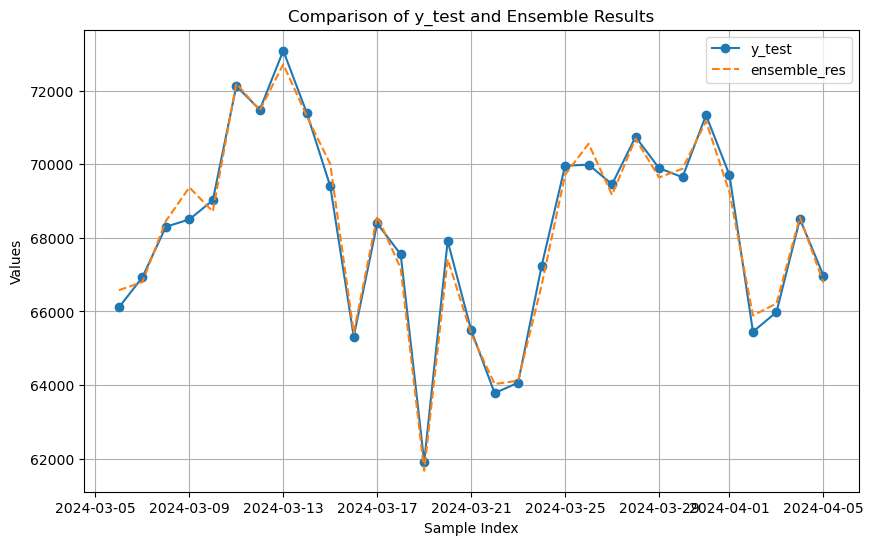

MSE: 116103.6386
RMSE: 340.7398
MAE: 278.3841


In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


features = pd.DataFrame({
    'xgb_res': xgb_res,
    'lgb_res': lgb_res,
    'cat_res': cat_res
})


model = LinearRegression()
model.fit(features, y_test)

coefficients = model.coef_
intercept = model.intercept_
print("回归方程为: y = {:.2f} + {:.2f}*xgb_res + {:.2f}*lgb_res + {:.2f}*cat_res".format(
    intercept, coefficients[0], coefficients[1], coefficients[2]))

ensemble_res = model.predict(features)

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='y_test', marker='o')
plt.plot(y_test.index, ensemble_res, label='ensemble_res', linestyle='--')
plt.title('Comparison of y_test and Ensemble Results')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# 计算MSE, RMSE, MAE
mse = mean_squared_error(y_test, ensemble_res)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, ensemble_res)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")